In [6]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats
from scipy.spatial import Voronoi, voronoi_plot_2d


# Quantification d'une loi continue

Objectif : Minimiser la distortion

## 1. Algorithmes pour la quantification scalaire. (dim=1)

On définit ci-dessous la fonction plusproche qui va calculer l'indice du centroïde le plus proche d'un point $X_{i}$ de notre échantillon $X_{cible}$.

Cette fonction nous sera très utile car elle permet de calculer l'indice du centre le plus proche d'un point en fonction d'une liste de centres que l'on peut actualiser au fur et à mesure.

Le principe est le suivant:

* Initialisation: on initialise la distance minimal courante au float le plus large et l'indice à -1. Si on le retrouve en sortie d'algorithme on pourra voir s'il y a un problème.

* Boucle sur la liste des centroïde: 
    1. On calcule la distance au centre de la cellule $C_{i}$ 
    2. On regarde si elle est plus petite que la distance minimale courante
    3. On associe l'indice à l'indice courant de la boucle si la condition est vérifiée.





In [27]:

def plusproche(Xi,lst_centre):
    """

    Entrée:
        Xi: Point i de notre échantillon cible parmis n points
        lst_centre: Liste des N-quantificateurs au moment de l'appel de la fonction


    Sortie:
        indice: indice du centroïde le plus proche
        dist_min: distance entre le point et le centre le plus proche

    """
    dist_min_cour=float('inf') # initialisation de dist_cour arbitrairement grand pour simplifier la règle de décision
    indice=-1 


    for i,ci in enumerate(lst_centre): # enumerate nous permet d'avoir accès au compteur et à l'objet itéré
        dist=np.abs(Xi-ci)**2 # Pour le cas muiltidimensionnel on remplace cette ligne par "dist=np.linalg.norm(Xi-ci)**2"
        if(dist<dist_min_cour):
            dist_min_cour=dist
            indice=i

    return indice,dist_min_cour
    
        

Remarques: 
* On choisit ici de calculer les distances avec $ | X_{i} - C_{i} |^{2} \ $ en dimension plutôt que la fonction np.linalg.norm car celle-ci rallonge considérablement les calculs.
* Cependant dans le cadre multidimensionnel, il faudra utiliser np.linalg.norm.

### 1.1 Algorithme de Kmeans (dim=1)

On définit la fonction kmeans_Lloyd.
Le principe de cette fonction est simple:


1. On parcourt la liste des points et on recherche pour chaque point son centroïde le plus proche et son indice.
2. On actualise les variables courantes Assignation,compteur, dist_total_it.
3. On actualise les centres à l'aide des variables courantes.
4. On récupère la distortion à l'itération it.
5. On passe à l'itération suivante



* Les rôles de ces variables courantes sont les suivantes:
    * Assignation_cour: somme les points les plus proches des associées au centroïdes d'indice $indice$ récupérée par plusproche
    * compteur_cour: compte le nombre de points associée au centroïde numéro $indice$
    * dist_cour_it: sommme les distances entre les point et leur centroïdes le plus proche à l'itération it



In [28]:
def kmeans_Lloyd(X,N,kmax=300):
    
    """
    Entrée:
        X: Echantillon de taille n x 1 suivant une densité f cible
        N: Nombre de quantificateur:
        kmax: nombre d'itération max
    
    Sortie:
        lst_centre: liste finale des centroïdes
        lst_proba: liste des probabilités associées aux centres
        dist_tab: tableau de l'évolution de la distortion


    """


    # Initialisation pour éviter les problèmes d'affectations
    X_cible=np.copy(X) # On récupère la taille de l'échantillon
    n=len(X_cible)
    lst_centre=npr.choice(X_cible,N) # N points choisis aléatoirement parmis l'échantillon
    #lst_centre=npr.normal(0,1,N)
    lst_centre=np.sort(lst_centre) # Tri des centres pour minimiser le problème de quantificateur isolée auquel aucun point n'est associé

    dist_tab=[] # Récupération de l'évolution de la distortion

    for it in range(kmax):
    # Initialisation des variables courantes à l'itération it
        Assignation_cour=np.zeros(N)  # pour une version multidimensionelle on peut remplacer la ligne par " Assignation_cour=np.zeros((N,X_cible.shape[1]))"
        compteur_cour=np.zeros(N)
        dist_total_it=0

        for x in X_cible:
            indice,dist_x=plusproche(x,lst_centre)

            # Actualisation des variables courante pour calculer le nouveau centre associé aux indices et de la distortion
            Assignation_cour[indice]=Assignation_cour[indice]+x
            compteur_cour[indice]+=1
            dist_total_it+=dist_x

        # Actualisation des centres
        for i in range(N):
            if(compteur_cour[i]>0):
                lst_centre[i]=Assignation_cour[i]/compteur_cour[i]
            else:
                lst_centre=lst_centre

        dist_tab.append(dist_total_it/(n))

    # Calcul des proba de chaque cellules
    lst_proba=compteur_cour/n

    return lst_centre, lst_proba, dist_tab


Remarques:
1. On se passe de mettre lst_centre en paramètre de la fonction car on les initialise en les choisissant parmis la liste X, ou bien, comme on connait la densité on peut directement les choisir suivant la densité.
2. L'étape la plus longue de cette algorithme, comme dit dans le LaTeX, est le calcul de plusproche. C'est pourquoi, pour avoir des temps de calculs raisonnables avec des grands échantillons X, il faut optimiser cette fonction.

#### 1.1.1 La loi uniforme sur $[0,1]$

In [37]:
n=1000
N=20
X_cible=npr.rand(n)

lst_centre_u_1d, lst_proba_u_1d, dist_tab_u_1d=kmeans_Lloyd(X=X_cible,N=N,kmax=300)

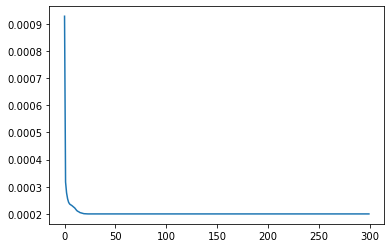

In [39]:
plt.plot(dist_tab_u_1d)
plt.show()

#### 1.1.2 La loi normal centrée réduite

In [40]:
n=1000
N=20
X_cible=npr.normal(0,1,n)

lst_centre_n_1d, lst_proba_n_1d, dist_tab_n_1d=kmeans_Lloyd(X=X_cible,N=N,kmax=300)

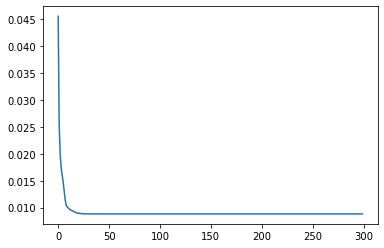

In [49]:
plt.plot(dist_tab_n_1d)

Quelques remarques:

1. On a choisit 1000 points et 300 itérations et on a déjà une dizaine de secondes de calculs (selon la puissance de la machine). On peut voir que si l'on augmente la taille de l'échantillon, on peut avoir des temps de calculs très long. ( voir la suite )
2. On peut voir que la distortion ne plus quasiment plus à partir de la vingtième itération.


In [48]:
print("Différence entre la distortion[20] et distortion[200] de la loi centrée réduite: \n",dist_tab_n_1d[20]-dist_tab_n_1d[200],"\n \n")
print("Différence entre la distortion[20] et distortion[200] de la loi uniforme sur [0,1]: \n ",dist_tab_u_1d[20]-dist_tab_u_1d[200])


Différence entre la distortion[20] et distortion[200] de la loi centrée réduite: 
 0.0001205041087765802 
 

Différence entre la distortion[20] et distortion[200] de la loi uniforme sur [0,1]: 
  5.657219834340893e-07


3. Cependant, comme illustrer ci dessus il est difficile d'introduire un critère d'arrêt car la fin de la forte décroissance de la distortion dépend de l'échantillon que l'on étudie.

### 1.2 Algorithme du gradient déterministe

#### 1.2.1 La loi normale centrée réduite

Concentrons nous sur le cas de la loi normale.

Tout d'abord, il faut calculer la direction de descente donnée par la fonction grad_list ci-dessous. (voir le LaTeX pour la formule explicite)




In [52]:
def grad_list(lst_centre):    
    N=len(lst_centre)
    grad=np.zeros(N)
    phi_plus=np.zeros(N)
    phi_moins=np.zeros(N)
    densi_plus=np.zeros(N)
    densi_moins=np.zeros(N)
    
    #On s'occupe d'abord des bords de la liste comme on actualise centre par rapport au précedent et au suivant dans la liste 
    
    grad[0]=lst_centre[0]*(scipy.stats.norm.cdf((lst_centre[0]+lst_centre[1])/2))+scipy.stats.norm.pdf((lst_centre[0]+lst_centre[1])/2)
    grad[N-1]=-lst_centre[N-1]*scipy.stats.norm.cdf((lst_centre[N-1]+lst_centre[N-2])/2)-scipy.stats.norm.pdf((lst_centre[N-1]+lst_centre[N-2])/2)
    
    for i in range(1,N-1):
        phi_plus[i]=scipy.stats.norm.cdf((lst_centre[i]+lst_centre[i+1])/2)
        phi_moins[i]=scipy.stats.norm.cdf((lst_centre[i]+lst_centre[i-1])/2)
        densi_plus[i]=scipy.stats.norm.pdf((lst_centre[i]+lst_centre[i+1])/2)
        densi_moins[i]=scipy.stats.norm.pdf((lst_centre[i]+lst_centre[i-1])/2)
        
        
    grad=lst_centre*(phi_plus-phi_moins)+densi_plus-densi_moins
    return grad

La méthode de gradient déterministe est donnée par la fonction method_Grad_normal.

Le principe est le suivant:

* On actualise les centres avec la formule suivante: lst_centre=lst_centre-gamma*grad_list(lst_centre)
* On calcule la distortion et on la stocke à l'aide des mêmes variables courantes que pour kmeans en dimension 1 (sauf Assignation_cour car nous n'en avons pas besoin).
* On passe à la itération suivante

In [76]:
def method_Grad_normal(X,N,gammainit,kmax=300):

    """"
    Entrée:
       Entrée:
        X: Echantillon de taille n x 1 suivant une densité f cible
        N: Nombre de quantificateur:
        gammainit: valeur du pas
        kmax: nombre d'itération max
        
    Sortie:
        lst_centre: liste finale des centroïdes
        lst_proba: liste des probabilités associées aux centres
        dist_tab: tableau de l'évolution de la distortion

    """
    # Initialisation pour éviter les problèmes d'affectations
    X_cible=np.copy(X)
    lst_centre=npr.normal(0, 1, N)
    lst_centre = np.sort(lst_centre)
    dist_cour=1
    dist_tab=[]
    compteur_cour=np.zeros(N)
    it=1
    
    while(it<kmax):
        compteur_cour=np.zeros(N)
        dist_cour=0
        gamma=gammainit
        lst_centre=lst_centre-gamma*grad_list(lst_centre)
        
        for x in X_cible:
            indice,dist_x=plusproche(x,lst_centre)
            dist_cour=dist_cour+dist_x
            compteur_cour[indice]+=1
        dist_tab.append(dist_cour/n)
        it+=1        
    lst_proba=compteur_cour/n
    if(it!=kmax):
        print("itération max non atteinte !")
    return lst_centre,lst_proba,dist_tab

In [77]:
npr.seed(200)
n=1000
N=20
X_cible=npr.normal(0,1,n)

lst_centre_grad, lst_proba_grad, dist_tab_grad=method_Grad_normal(X_cible,N,0.9,kmax=300)

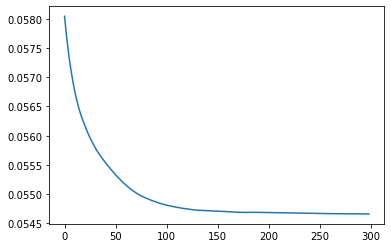

In [78]:
plt.plot(dist_tab_grad)

Remarques:
1. On a sensiblement le même temps de calcul car on utilise autant de fois la fonction plusproche.
2. Le défi de cette algorithme est de trouvé le pas le plus adapté pour minimiser la distortion le plus rapidement possible.

In [79]:
x=np.linspace(0,1,20)
min_tab=[]
for gamma_i in x:
    lst_centre_grad, lst_proba_grad, dist_tab_grad=method_Grad_normal(X_cible,N,gamma_i,kmax=300)
    min_tab.append(dist_tab_grad[-1])


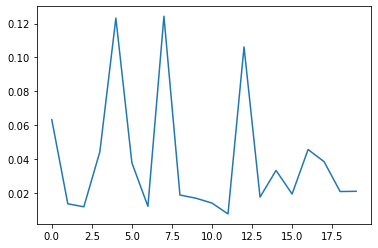

In [80]:
plt.plot(min_tab)

## 2. Algorithmes pour la quantification vectorielle

On propose une version beaucoup plus optimisée de plusplus en dimension supérieure afin de limiter les temps de calculs dû au passage à une dimension supérieure.

In [9]:
def plusproche_d(Xi,lst_centre):
    """

    Entrée:
        Xi: Point i de notre échantillon cible parmis n points
        lst_centre: Liste des N-quantificateurs au moment de l'appel de la fonction


    Sortie:
        indice: indice du centroïde le plus proche
        dist_min: distance entre le point et le centre le plus proche

    """
    indice=-1 
    dist_tab = np.linalg.norm(lst_centre - Xi, axis=1)
    indice = dist_tab.argmin()
    
    return indice, dist_tab[indice]
    

### 2.1 Algorthimes de kmeans

On redéfinit de la même manière kmeans en dimension 2 pour un échantillon gaussien centrée réduit.

In [10]:
def kmeans_Lloyd_d(X,n,N,kmax=300):
    
    """
    Entrée:
        X: Echantillon de taille n x m suivant une densité f cible
        N: Nombre de quantificateur:
        kmax: nombre d'itération max
    
    Sortie:
        lst_centre: liste finale des centroïdes
        lst_proba: liste des probabilités associées aux centres
        dist_tab: Tableau de l'évolution de la distortion


    """


    # Initialisation pour éviter les problèmes d'affectations
    X_cible=np.copy(X) # On récupère la taille de l'échantillon
    lst_centre=npr.normal(0, 1, size=[N, 2]) # size = [N,d] pour la dimension d
    

    dist_tab=[] # Récupération de l'évolution de la distortion

    for it in range(kmax):
    # Initialisation des variables courantes à l'itération it
        Assignation_cour=np.zeros((N,2)) # idem que pour lst_centre
        compteur_cour=np.zeros(N)
        dist_total_it=0

        for x in X_cible:
            indice,dist_x=plusproche_d(x,lst_centre)

            # Actualisation des variables courante pour calculer le nouveau centre associé aux indices et de la distortion
            Assignation_cour[indice]=Assignation_cour[indice]+x
            compteur_cour[indice]+=1
            dist_total_it+=dist_x

        # Actualisation des centres
        for i in range(N):
            if(compteur_cour[i]>0):
                lst_centre[i]=Assignation_cour[i]/compteur_cour[i]
            else:
                lst_centre=lst_centre

        dist_tab.append(dist_total_it/(2*n))

    # Calcul des proba de chaque cellules
    lst_proba=compteur_cour/n

    return lst_centre, lst_proba, dist_tab


In [12]:
n=1000
N=50
X_cible=npr.normal(0,1,size=[n,2])

lst_centre_n_2d, lst_proba_n_2d, dist_tab_n_2d=kmeans_Lloyd_d(X_cible,n,N,300)

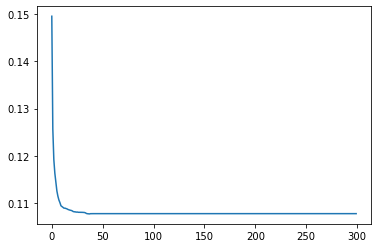

In [13]:
plt.plot(dist_tab_n_2d)


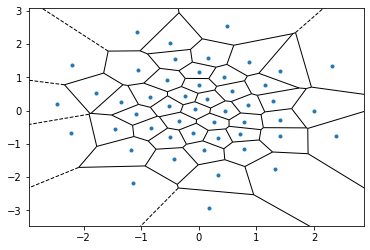

In [14]:
vor=Voronoi(lst_centre_n_2d)
fig = voronoi_plot_2d(vor,show_vertices=False)
plt.show()

### 2.2 Competitive Learning Vector Quantization (CLVQ)

Le choix du pas est crucial dans notre problème pour s'assurer que l'algorithme converge en un nombre raisonnable d'itérations. Nous décidons de le définir suivant l'expression de 3.2.2 de Optimal quadratic quantization for numerics: the Gaussian
case.Gilles PAGES,Jacques PRINTEMS

In [16]:
def gamma_n(it,N):
    gamma_0=0.1
    a = 4.0 * N
    b = np.pi ** 2 / N 
    return gamma_0*a/(a+b*it)

In [49]:
def CLVQ_normal(X,n,N,kmax=100):
    X_cible=np.copy(X) # On récupère la taille de l'échantillon
    lst_centre=npr.normal(0, 1, size=[N, 2])

    lst_tab=[lst_centre]

    dist_tab=[] # Récupération de l'évolution de la distortion

    for it in range(kmax):
    # Initialisation des variables courantes à l'itération it

        compteur_cour=np.zeros(N)
        dist_total_it=0
        for x in X_cible:
            #Phase de compétition
            indice,dist_x=plusproche_d(x,lst_centre)

            #Phase d'apprentissage            
            lst_centre[indice]=lst_centre[indice]-gamma_n(n*it,N)*(lst_centre[indice]-x)
            
            # Actualisation des variables courante pour calculer le nouveau centre associé aux indices et de la distortion
            compteur_cour[indice]+=1
            dist_total_it+=dist_x
        if(it % 10 == 0 ):
            lst_tab.append(lst_centre)
        dist_tab.append(dist_total_it/(2*n))
        print(compteur_cour)
    # Calcul des proba de chaque cellules
    lst_proba=compteur_cour/n

    return lst_centre, lst_proba, dist_tab,lst_tab


In [50]:
npr.seed(0)
n=10000
N=15
X_cible=npr.normal(0,1,n)

lst_centre_clvq, lst_proba_clvq, dist_tab_clvq,lst_tab=CLVQ_normal(X_cible,n,N,100)

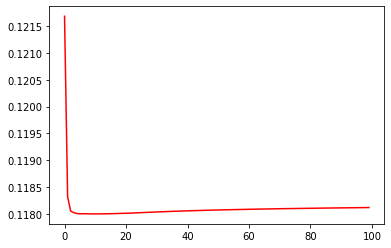

In [51]:

plt.plot(dist_tab_clvq,color="red")

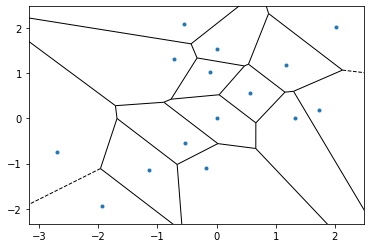

In [52]:
vor2=Voronoi(lst_centre_clvq)
fig = voronoi_plot_2d(vor2,show_vertices=False)
plt.show()

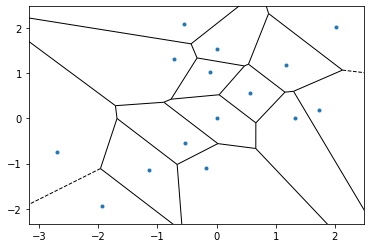

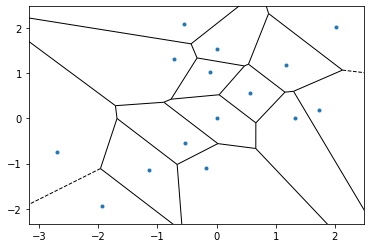

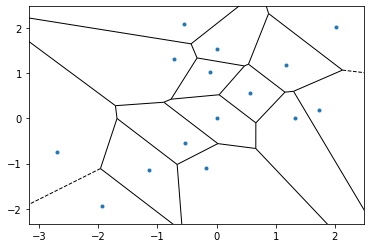

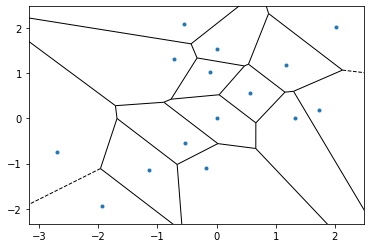

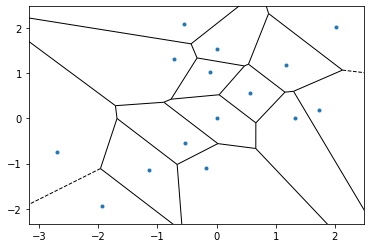

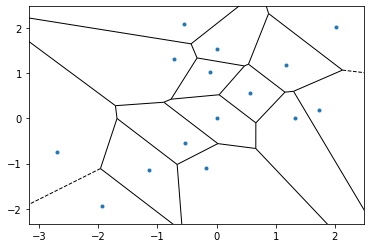

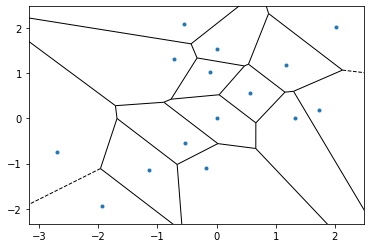

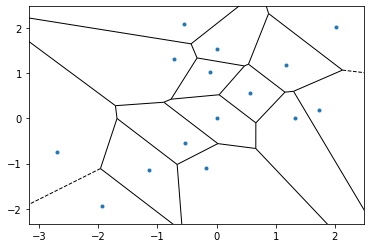

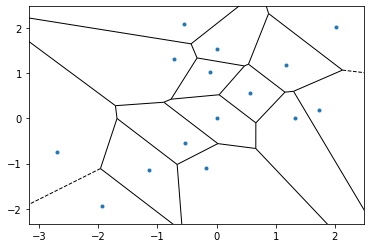

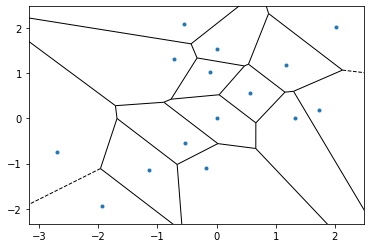

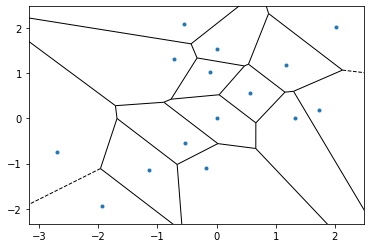

In [53]:
for lst in lst_tab:
    vor_temp=Voronoi(lst)
    fig = voronoi_plot_2d(vor_temp,show_vertices=False)
    plt.show()